# Install packages

In [ ]:
#----install stuff
!pip install mlxtend
!pip install -U imbalanced-learn
!python ../../software/python-glmnet/setup.py
!conda install -c conda-forge tensorflow
!conda install -c conda-forge keras

# Import

In [76]:
from funcs_general import *
pd.options.mode.chained_assignment = None

# Model and evaluation

In [12]:
from funcs_general import *

# ---------------- import
from sklearn import base
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve

# models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFECV
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import FunctionTransformer

#from glmnet import LogitNet
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as ImbPipe

#from xgboost import XGBRegressor


def PowLog(X):
    X=pd.DataFrame(X)
    Xpow=X.apply(lambda row: np.power(row,2), axis=1)
    X = pd.concat([X, Xpow], axis=1)
    return X
    
FeaturePowLog = FunctionTransformer(PowLog)


#--------calculate fees
def get_fees(returns,FEE_BUY,FEE_SELL):
    returns=np.array(returns)
    v=np.repeat(0.0,len(returns))
    for i in np.arange(len(returns)):
        if returns[i] != 1: v[i] = (returns[i] * FEE_BUY + returns[i] * FEE_SELL)
    return v

#-----calculate ROI depending on cutoff value
def get_ROI(test,y_pred,strategy="reinvest"):
    
    
    test['y_pred'] = y_pred
    test['return'] = 1.0
    test.loc[test.y_pred == 1,'return']  = test.loc[test.y_pred == 1,'target'] + 1
    
    test['lags'] = np.concatenate((np.array([0.0]),np.diff(np.array(test.timstamp), n=1, axis=-1)), axis=0)
    test['trade'] = test['y_pred']
    
    if (SKIP_TRADE > 0) : 
        test['trade']  = skip_trades(test['trade'].values,test['lags'].values,SKIP_TRADE)
        test.loc[test.trade == 0,'return']  = 1
        
    if (strategy=="reinvest"):
        test['fees'] = get_fees(test['return'],FEE_BUY,FEE_SELL)  
        test['return_cum'] = np.cumprod(np.array(test['return']) - np.array(test['fees']) )
        #test['return_cum']=test['return_cum'] - test['fees'] 
        
    if (strategy=="fixed") : 
        test['return_cum'] = 1 + np.cumsum(test['return'].values - 1)
        test['fees'] = np.where(test['return'] != 1,(FEE_BUY+FEE_SELL),0)
    
    ROI = float(test['return_cum'].tail(1))
    fees = sum(test['fees'])
    
    trades = sum(test['trade'])
    days = (float(test.timstamp.tail(1)) - float(test.timstamp.head(1))) / 3600 / 24
    
    out=pd.DataFrame({'ROI': [ROI], 'ROI_bench' : test.mid.values[-1:] / test.mid.values[0],
                      'ROI_day' : [ROI/days],
                      'trades' : [trades], 'days' : [days], 'strategy' : [strategy] })
    return  {'kpis' : out, 'data' : test}


#------once traded, wait until previous trade was completed. Skip test cases until gap > time_future
def skip_trades(trade,lags,seconds):
  
    counter=[0.0]
    counting = False

    for i in np.arange(len(trade)):

        # set value to 1
        if counting == True:
            trade[i] = 0
            counter.append(lags[i])

        # ON
        if trade[i] ==1: counting = True

        # OFF
        if sum(counter) > seconds:
            counter=[0.0]
            counting = False

    return trade

#-----optimization: find best cutoff for max ROI
from scipy.optimize import minimize_scalar

def find_opt_ROI(cutoff):
    y_pred=np.where(test.y_pred_prob >= cutoff, 1,0) 
    obj_ROI = get_ROI(test,y_pred,strategy="reinvest")
    roi=float(obj_ROI['kpis']['ROI'].values)
    if (roi < 0) : roi = 0.0001
    return float(-roi)


import itertools
def expandgrid(*itrs):
   product = list(itertools.product(*itrs))
   return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))}

def eval_model(test,cutoff):

    if TYPE == "classify": bounds=(0,1)
    if TYPE == "regression": bounds=(0,0.015)
    
    if cutoff < 0:
        best_cutoff=minimize_scalar(find_opt_ROI,bounds=bounds, method='bounded',options={'maxiter' : 500000})
        cutoff=best_cutoff['x']
    
    y_pred=np.where(test.y_pred_prob.values >= cutoff, 1,0) 
    if hasattr(MODEL,'scoring'): model_scoring = MODEL.scoring
    else: model_scoring = None
    
    
    obj_ROI = get_ROI(test,y_pred,strategy="reinvest")
    obj_ROI['kpis']['max_trades'] = confusion_matrix(test.target_cat, y_pred)[1,0]
    obj_ROI['kpis']['days_trading'] = len(set([str(datetime.fromtimestamp(e).date()) for e in test.iloc[np.where(y_pred == 1)[0],:]['timstamp'].values]))
    obj_ROI['kpis']['cutoff'] = cutoff
    obj_ROI['kpis']['precision'] = precision_score(test.target_cat,y_pred,pos_label=1)
    obj_ROI['kpis']['DIRECTION'] = DIRECTION
    obj_ROI['kpis']['THRES_PROF'] = THRES_PROF
    obj_ROI['kpis']['TARGET_TIME']=TARGET_TIME
    obj_ROI['kpis']['TRAIN_THRES']=TRAIN_THRES
    obj_ROI['kpis']['N_TRAIN']=N_TRAIN
    obj_ROI['kpis']['MODEL_SCORER'] = model_scoring
    obj_ROI['kpis']['TYPE']=TYPE
    o=obj_ROI['data']
    #o.loc[o['trade']==1,o.columns[-9:]]
    return obj_ROI

from sklearn.metrics import make_scorer

#-----------precision custom scorer
def custom_precision(y_true,probas_pred): 
    pos_label=1
    precision, recall, _ = precision_recall_curve(y_true,probas_pred,pos_label=pos_label)
    cut = np.where(precision >= 0.5)[0]
    if len(cut) <= 1: area = 0
    else: area = auc(recall[cut], precision[cut])
    area = auc(recall, precision)
    return area

def custom_precision_wrapper(y_true,probas_pred):
    return custom_precision(y_true,probas_pred[:, 1])

#------MAXIMIZE: bigger is better!
score_custom_precision = make_scorer(custom_precision_wrapper,greater_is_better=True,needs_proba=True)

#------------custom regression scorers

def custom_score_regression1(y_true,y_pred): 
    
    y_pred=np.array(y_pred)
    y_true=np.array(y_true)
    
    #  money 
    i_in = np.where(y_true >= THRES_PROF)[0]
    i_out = np.where(y_true < THRES_PROF)[0]
    
    
    # >= 0.0042 in the money
    list_i = []
    for i in i_in:
        if y_pred[i] >= y_true[i]: list_i.append( (y_pred[i]- y_true[i]) * 1 )
        if y_pred[i] < y_true[i]: list_i.append( (y_true[i]- y_pred[i] ) * 0 )
    
    # < 0.0042 out of money 
    for i in i_out:
        if y_pred[i] >= THRES_PROF: list_i.append( abs(y_pred[i] - y_true[i]) * 10 )
        if y_pred[i] < THRES_PROF: list_i.append(0)
    
    out = sum(np.array(list_i)) / (len(i_in))
    print('in, out, score: ',len(i_in), len(i_out) ,out)
    
    return out

def custom_score_regression2(y_true,y_pred): 
    
    
    THRES=TRAIN_THRES
    
    y_pred=np.array(y_pred)
    y_true=np.array(y_true)
    
    # punish false positives
    i_wrong = np.where((y_pred > THRES) & (y_true <= THRES))[0]
    wrong = y_true[i_wrong] - THRES
    wrong = abs(wrong * 3)
    loss1 = np.sum(wrong)
    av_loss1 = loss1/len(wrong)
    
    # punish false negatives
    i_missed = np.where((y_pred < THRES) & (y_true >= THRES))[0]
    missed = y_true[i_missed] - THRES
    missed = abs(missed)
    loss2 = np.sum(missed * 2)
    av_loss2 = loss2/len(missed)
    
    out=np.nansum([av_loss1,av_loss2])
    
    print(len(wrong), len(missed), out)
    return out


#------MINIMIZE: smaller is better!
score_custom_regression = make_scorer(custom_score_regression2,greater_is_better=False)

#custom_score_regression(test.target.values,test.y_pred_prob)

# Feature transformers

In [13]:
def transform_features(X):
    # feature transformation: take sqrt of count data
    for e in X.filter(regex=('count$')).columns: X[e] = np.sqrt(X[e] )
    return X

# Classification pipeline

In [35]:
#--------classification pipe
sm=SMOTEENN(random_state=1,ratio='minority')
sm=SMOTE(random_state=1,ratio='minority')
#clf2=LogitNet(fit_intercept=True,alpha=0,n_splits=3,n_jobs=1, scoring=score_custom_precision)
#fsel=RFECV(clf1,step=1, cv=TimeSeriesSplit(n_splits=2), scoring="log_loss", verbose=0, n_jobs=1)
pipe=ImbPipe([
            ('ft', FunctionTransformer(transform_features,validate=False)),
            ('rs', StandardScaler()), 
            ('pca',PCA()),
            #('fs', fsel), 
            ('sm', sm), 
            ('clf1',LogisticRegression(fit_intercept=True,C=0.001))
            ])
params = {
          'clf1__C': [0.0001,0.0005,0.001,0.003,0.005,0.01,0.05],
            'clf1__penalty': ['l1']
         }
grid1 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=16,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2),
                    scoring="log_loss")
grid2 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=16,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2),
                    scoring=score_custom_precision)

# Backtesting function rolling window timeseries

In [15]:
import warnings
warnings.filterwarnings("ignore")

def backtesting(d):
    gc.collect()
    cv=TimeSeriesSplit(n_splits=BACKTEST_SPLITS,max_train_size=N_TRAIN_MIN)
    test_list = []
    best_params=[]
    for i in cv.split(d):
        
        i_train, i_test = i
        print(len(i_train))
        
        if (len(i_train) >= N_TRAIN_MIN):
            
            # Set training N
            i_train = i_train[-N_TRAIN:] 
            X=d.iloc[i_train,:]
            X = X[(X.target >= TRAIN_THRES) | (X.target < THRES_PROF) ] 
            
            target_freq = np.sum(X.target_cat) / N_TRAIN * 2
            #new=d.iloc[0:i_train[0],:]
            #new=new[(new.target >= TRAIN_THRES)]
            #X = new.append(X)
            
            print(i_test[0],i_test[-1:],sum(X.target_cat),sum(X.target_cat)/X.shape[0])
            
            if TYPE == "classify": y= X.target_cat    
            if TYPE == "regression": y= X.target
                
            X=X.loc[:,FEATURES]
            test=d.iloc[i[1],:]

            MODEL.fit(X,y)

            if (hasattr(MODEL,'best_estimator_')) == True: PREDICTOR = MODEL.best_estimator_
            if (hasattr(MODEL,'best_estimator_')) == False: PREDICTOR = MODEL

            if TYPE == "classify":
                y_pred_prob2=PREDICTOR.predict_proba(test.loc[:,FEATURES])
                test['y_pred_prob'] = np.asarray([p[1] for p in y_pred_prob2 ])

            if TYPE == "regression":
                test['y_pred_prob'] = PREDICTOR.predict(test.loc[:,FEATURES])

            if (hasattr(MODEL,'best_estimator_')):
                best_params.append(MODEL.best_params_)
                print(MODEL.best_params_, MODEL.best_score_)

            test_list.append(test)

    test = pd.concat(test_list)
    return test

# Data prep

In [5]:
def prep_data(data):
    target = 'mid' + str(TARGET_TIME)
    d=dr.dropna(subset=[target])
    d['target'] = d[target]
    if DIRECTION == "short": d['target'] = -1 * d['target'] 
    d['target_cat'] = np.where(d['target'] >= THRES_PROF, 1,0)
    return d

In [6]:
# -------load data
dr=pd.read_csv("training_data/bitfinex_btcusd.csv.gz")
DAYS=ma.ceil((dr.timstamp[-1:] - dr.timstamp[1])/3600/24)

In [16]:
dr.columns
print(dr.shape)
print(DAYS)

(463165, 35)
19


# Brute force test thresholds for data selection

In [ ]:
result=[]
runner=pd.DataFrame(expandgrid(
                ['long'],
                [0.004081],
                [pipe],
                [100000,150000],
                [0.0042,0.006,0.007,0.008,0.009,0.01,0.012,0.014,0.016,0.018,0.02,0.022,0.024,0.026],
                #[0.013,0.014,0.015],
                [300,60,900]
))
runner.columns = ['DIRECTION','THRES_PROF','MODEL','N_TRAIN','TRAIN_THRES','TARGET_TIME']

print('brute force runs: ' + str(len(runner)))

for i in np.arange(0,runner.shape[0]):
    print('#----------------' + str(i))
    with open('log_backtest.txt', 'a') as f: f.write('#----------------' + str(i) + ' of ' +str(runner.shape[0]) )
    DIRECTION = runner.loc[i,'DIRECTION']
    THRES_PROF = runner.loc[i,'THRES_PROF']
    TARGET_TIME = runner.loc[i,'TARGET_TIME']
    TRAIN_THRES = runner.loc[i,'TRAIN_THRES']
    N_TRAIN = runner.loc[i,'N_TRAIN']
    N_TRAIN_MIN = 150000
    SKIP_TRADE=TARGET_TIME
    FEE_BUY=0.002
    FEE_SELL=0.002
    TYPE="classify"
    TRAIN_STRATEGY = "NONE"
    MODEL=runner.loc[i,'MODEL']
    BACKTEST_SPLITS=10
    d=prep_data(dr)
    FEATURES = d.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns
    gc.collect()
    try:
        test=backtesting(d)
        r=eval_model(test,-999)['kpis']
        result.append(r)
        pd.concat(result).sort_values("ROI",ascending=False).to_csv('models_brute.csv')
    except Exception as e: 
        print(e)
        with open('log_backtest.txt', 'a') as f: f.write('#----------------' + str(i) + str(e))

In [ ]:
pd.concat(result).sort_values('ROI',ascending=False).head(3)

# Selected model

In [79]:
#--------------BACKTESTING
DIRECTION = 'long'
THRES_PROF = 0.004081
TARGET_TIME = 120
TRAIN_THRES=0.0041
N_TRAIN = 150000
N_TRAIN_MIN = 150000
N_WINDOW_MIN = 150000
SKIP_TRADE=TARGET_TIME
TYPE="classify"
TRAIN_STRATEGY = "NONE"
MODEL=pipe
BACKTEST_SPLITS=19
d=prep_data(dr)
FEATURES = d.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns
test=backtesting(d)

22058
44098
66138
88178
110218
132258
150000
154298 [176337] 4321 0.0288205005069
150000
176338 [198377] 3741 0.0249521433764
150000
198378 [220417] 4422 0.0294957310566
150000
220418 [242457] 4608 0.0307374178701
150000
242458 [264497] 5496 0.0366602853579
150000
264498 [286537] 7280 0.0485627947622
150000
286538 [308577] 8737 0.0582898011195
150000
308578 [330617] 9434 0.0629483081892
150000
330618 [352657] 9698 0.064710710163
150000
352658 [374697] 8635 0.0576131412673
150000
374698 [396737] 8086 0.0539476668935
150000
396738 [418777] 10803 0.0720714109398
150000
418778 [440817] 13777 0.0919011947089


        ROI  ROI_bench   ROI_day       days  strategy  trades  max_trades  \
0  1.175559   0.656227  0.099043  11.869212  reinvest     116       23321   

   days_trading  cutoff  precision DIRECTION  THRES_PROF  TARGET_TIME  \
0             5    0.99    0.43151      long    0.004081          120   

   TRAIN_THRES  N_TRAIN MODEL_SCORER      TYPE  
0       0.0041   150000         None  classify  


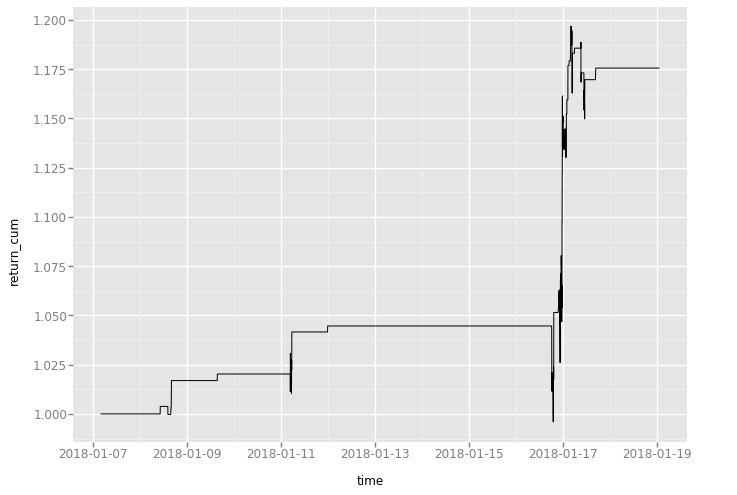

<ggplot: (8777364135779)>

In [78]:
FEE_BUY=0
FEE_SELL=0
#eval_model(test,-999)['kpis']
kpi_obj=eval_model(test,0.99)
kpi_data = kpi_obj['data']
kpi_data['time'] = [datetime.fromtimestamp(e) for e in kpi_data.timstamp.values]
print(kpi_obj['kpis'])
from ggplot import *
p=ggplot(aes(x='time', y='return_cum'), data=kpi_data) #[kpi_data['return'] != 1.0]
p + geom_line()

# TPOT genetic algorithms

In [ ]:
'''
from tpot import TPOTClassifier
TYPE="classify"
TRAIN_STRATEGY = "NONE"
MODEL={'scoring' : 0}
THRES_PROF = 0.00402
TARGET_TIME = 800
TRAIN_THRES=0.012
N_TRAIN = 200000

d=prep_data(dr)
FEATURES = d.filter(regex=('width$|^(imba)|^(adj)|^(tr)|^(t[0-9])|^(agg)|(mid$)')).columns

tpot = TPOTClassifier(generations=10, population_size=20, verbosity=2,
                      scoring="log_loss",random_state=1,n_jobs=12,cv=TimeSeriesSplit(max_train_size=200000,n_splits=3,))

splits=10
cv=TimeSeriesSplit(n_splits=splits,max_train_size=400000)
i_train, i_test = [i for i in cv.split(d)][splits-1]
print(i_test.shape)
X=d.iloc[i_train,:]
X = X[(X.target >= TRAIN_THRES) | (X.target < THRES_PROF) ]
test = d.iloc[i_test,:]

tpot.fit(X[FEATURES], X.target_cat)
y_pred_prob2 = tpot.predict_proba(test[FEATURES])
test['y_pred_prob'] = np.asarray([p[1] for p in y_pred_prob2 ])

#tpot.export('tpot_mnist_pipeline.py')
#t=tpot.clean_pipeline_string
'''
tpot.fitted_pipeline_

# Regression pipeline (imbalanced)

In [ ]:
'''
#--------regression pipe
pipe=ImbPipe([
            ('ft', FunctionTransformer(transform_features,validate=False)),
            ('rs', StandardScaler()), 
            ('pca',PCA()),
            ('enet',ElasticNet(random_state=1,alpha=0.001,l1_ratio=0))
])

params = {
          'enet__alpha': [0.001,0.005,0.01],
         'enet__l1_ratio': [0,0.001,0.01]
         }
grid0 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=16,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2),
                    scoring=score_custom_regression)
'''

# Keras pipeline

In [ ]:
#-----neural network pipe
'''
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

# Function to create model, required for KerasClassifier
def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=40, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
np.random.seed(0)
# create model
nnet = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

pipe=ImbPipe([
            ('ft', FunctionTransformer(transform_features,validate=False)),
            ('rs', StandardScaler()), 
            ('nnet',nnet)
])

# define the grid search parameters
params = dict(neurons=[1,2,5])

#grid3 = GridSearchCV(estimator=pipe,refit=True,param_grid=params,n_jobs=16,verbose=0,
                    cv=TimeSeriesSplit(n_splits=2),
                    scoring="log_loss")
'''